<a href="https://colab.research.google.com/github/MatiasCovarrubias/jaxecon/blob/main/Value_Function_Iteration_with_TPUs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dynamic Programming in TPUs Using JAX

This colab notebook explores best practices to parallelize code using JAX, with a focus on how to leverage TPUs. Our starting point is Sargent and Stachurski's notebook on how to use JAX and GPUS to perform heaviliy optimized vectorization https://notes.quantecon.org/submission/622ed4daf57192000f918c61. For large state spaces, we get a 10x speed gain when using TPUs. I show that in order to get such speed bump we need to, in addition to vectorize, parallelize the value function update across the 8 cores of a TPU. Also, I show that automatic vectorization using jax.vmap gets close in terms of speed to manual vectorization, while being easier to get right and more generally applicable. 

The problem is to maximize the expected discounted sum

$$ 𝔼\sum_{t≥0} β^t u(c_t)$$

subject to

$$c_t+a_t+1≤Ra_t+yt, \quad c_t≥0,\quad a_t≥0$$

for all $t≥0$, with $a_0$ and $y_0$ given. Here $c_t$ is consumption, $a_t$ is assets, $R$ is the gross risk-free rate of return, and $y_t$ is income. The income process follows a Markov chain with transition matrix $P$.

The Bellman equation is

$$v(a,y)= \underset{0≤a′≤Ra+y}{\max} \{ u(Ra+y−a′)+β\sum_{y′}v(a′,y′)P(y,y′) \}$$

where $v$ is the value function. The corresponding Bellman operator is

$$Tv(a,y)= \underset{0≤a′≤Ra+y}{\max} \{ u(Ra+y−a′)+β\sum_{y′}v(a′,y′)P(y,y′) \}$$

We solve the dynamic program by value function iteration --- that is, by iterating with T.


Here is a preview of the time (in secods) that it take to do un update of the value function under the different parallelization schemes we will review:

State Space size $\to$  |	131,072	|	2,097,152	|	8,388,608	|	33,554,432	|	134,217,728
-------------------|-------|-------|-------|-------|-------
GPU, manual vectorization | 0.0040	|	0.1979	|	1.5700	|	12.1128	|	97.4787
GPU, auto. vectorization |	0.0048	|	0.2975	|	2.3174	|	20.6630	|	224.7583
TPU, manual vectorization | **0.0033**	|	0.0988	|	0.7798	|	6.2468	|	49.9455
TPU, auto. vectorization | 0.0034	|	0.1263	|	0.9292	|	7.4162	|	59.2860 
TPU parallelization | 0.0272	|	**0.0562**	|	**0.2108**	|	**1.2765**	|	**9.7084** 

The header of each column represents the size of the state space. It is worth noticing that increase the size of the grid for $a$ and $y$ not only increase the number of points in the state space grid but also increase the cost of the update in each point, because the number of possible $a'$ also increase and calculating the expectation term requires more computation. 


We will start by installing quantecon and importing the libraries we will use and configuring TPU if needed.

In [ ]:
# installs
!pip install -U quantecon # Install quantecon in case it's missing

#imports
import numpy as np
import jax
import jax.numpy as jnp
from numba import njit
import quantecon as qe 
import matplotlib.pyplot as plt
import timeit
from jax.config import config
config.update("jax_log_compiles", 1)
# to suppress watnings uncomment next two lines
# import warnings
# warnings.filterwarnings('ignore')

#chage to False if using CPU or GPU runtime.
use_TPU = False
if use_TPU:
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
else:
  !nvidia-smi


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 179 kB 14.4 MB/s 


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Thu Jul  7 18:11:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In the case you chose a GPU runtime, if you don't use Colab Pro, you should get something lika a Tesla K80. Since I am using Colab Pro, I got a Tesla P100.

# Starting Point: Naive implementation on a small grid

Next, we specify global parameters (we will then move it to local), the grids for the state and actions, and the inital value for the value function. 

In [ ]:
# grid for assets
#scale = 1/64
scale = 32

a_min, a_max = 0.01, 2
ρ = 0.9
σ = 0.1
a_size = ap_size = int(1024*scale)
a_grid = jnp.linspace(a_min, a_max, a_size)  # grid for a
ap_grid = jnp.linspace(a_min, a_max, a_size)                 # grid for a'
#grid for y (use QuantEcon's tauchen() function to create Markov Chains out of AR(1))
ρ = 0.9
σ = 0.1
y_size = int(128*scale)
mc = qe.tauchen(ρ, σ, n=y_size)
y_grid = jnp.exp(mc.state_values)
P = jnp.array(mc.P)

# Organize in dictionaries
params = {
    "R": 1.1,
    "beta": 0.99,
    "gamma": 2.5
}

grids = {
  "a": a_grid,
  "y": y_grid,
  "ap": ap_grid,}

model = {"params": params, 
        "grids": grids, 
        "Trans_matrix": P, 
        "indices": {"a": jnp.array(range(a_size)), "y": jnp.array(range(y_size)), "ap": jnp.array(range(ap_size))},
         "batched_grids": {}}

# initial value
v_init = np.zeros((a_size, y_size))

We are going to start by using a nainve approach that uses for loops extensively. This structure is going t o be the base of our "authomatically vectorized" version.

In [ ]:
def T_naive(v, model):
  params = model["params"]
  grids = model["grids"]
  P = model["Trans_matrix"]
  
  def u(c):
      return c**(1-params["gamma"]) / (1-params["gamma"])

  "The Bellman operator."
  # Allocate memory
  v_new = np.empty_like(v)
  # Step through all states
  for i, a in enumerate(a_grid):
      for j, y in enumerate(y_grid):
          # Choose a' optimally by stepping through all possible values
          v_max = - np.inf
          for k, ap in enumerate(ap_grid):
              c = params["R"] * a + y - ap
              if c > 0:  
                  # Calculate the right hand side of the Belllman operator
                  val = u(c) + params["beta"] * np.dot(v[k, :], P[j, :])
                  if val > v_max:
                      v_max = val
          v_new[i, j] = v_max
  return v_new

%time T_naive(v_init, model)

CPU times: user 6.63 s, sys: 11.8 s, total: 18.5 s
Wall time: 12.7 s


array([[-1.86624002, -0.23726241],
       [-1.27407837, -0.21337929],
       [-0.93996847, -0.19325423],
       [-0.73004103, -0.17609487],
       [-0.58810759, -0.16135961],
       [-0.48685074, -0.14854133],
       [-0.41164595, -0.13733099],
       [-0.354004  , -0.12747793],
       [-0.30863982, -0.1187598 ],
       [-0.27222025, -0.1109712 ],
       [-0.24243763, -0.10400578],
       [-0.21771047, -0.09774285],
       [-0.19692048, -0.09208323],
       [-0.17923257, -0.08694786],
       [-0.164065  , -0.08227308],
       [-0.15090549, -0.07800293]])

## Manual vectorization: Reshape grids and transition matrix


We add dimensions to arrays so that they will be stretched along the new dimensions when placed in arithmetic operations with other arrays that have more elements along those dimensions. This stretching is done by repeating values, which is what we use to replace loops.

The next code cell reshapes all arrays to be three-dimensional.

In [ ]:
model["batched_grids"] = {
    "P": jnp.reshape(P, (y_size, y_size, 1)),
    "a": jnp.reshape(a_grid, (a_size, 1, 1)),
    "y": jnp.reshape(y_grid, (1, y_size, 1)),
    "ap": jnp.reshape(ap_grid, (1, 1, ap_size)),
}

Now we can implement a vectorized version of the Bellman operator, which calculates the same values.

In [ ]:
def get_T_manualvec(model: dict):
  params = model["params"]
  a = model["batched_grids"]["a"]
  y = model["batched_grids"]["y"]
  ap = model["batched_grids"]["ap"]
  P = model["batched_grids"]["P"]
  
  def u(c):
      return c**(1-params["gamma"]) / (1-params["gamma"])

  def T_manualvec(v):
      vp = jnp.dot(v, P) # vp has shape (a_size, y_size, 1)
      c = params["R"] * a + y - ap # c has shape (a_size, y_size, ap_size)
      # m = jnp.where(c > 0, u(c) + β * vp, -np.inf) # m has shape (a_size, y_size, ap_size) 
      m = u(c) + params["beta"] * vp # m has shape (a_size, y_size, ap_size) 
      return jnp.max(m, axis=2) # we to average over the last axis, that is, for each a and y, get the the max over ap.
    
  return T_manualvec


Now wer are gonig to precompile the T operation so JAX optimize it use of the hardware.

In [ ]:
T_manualvec = get_T_manualvec(model)
T_manualvec_jit = jax.jit(T_manualvec).lower(v_init).compile()
%time T_manualvec_jit(v_init).block_until_ready()

CPU times: user 451 µs, sys: 3.86 ms, total: 4.31 ms
Wall time: 2.62 ms


DeviceArray([[        nan, -0.23726259],
             [        nan, -0.21338044],
             [        nan, -0.1932523 ],
             [        nan, -0.17610094],
             [        nan, -0.16134453],
             [        nan, -0.14853972],
             [        nan, -0.13734336],
             [        nan, -0.12748614],
             [        nan, -0.11875407],
             [        nan, -0.11097524],
             [        nan, -0.10401004],
             [-0.21771078, -0.09774413],
             [-0.19691947, -0.09208304],
             [-0.17923889, -0.08694804],
             [-0.1640543 , -0.08227319],
             [-0.1508989 , -0.07800273]], dtype=float32)

With a Tesla P100 GPU, we get 30ms. With TPU, we get 16.9

## Authomatic vecotrization using vmap

When we calculate the value function at each point of the grid, we want to pass all the possible actions as a vector, and then calculate the maximum. In order to get the actio_value for all the possible actions, we are going to use vmap.

When we calculate the value function at each point of the grid, we want to pass all the possible actions as a vector, and then calculate the maximum. In order to get the actio_value for all the possible actions, we are going to use vmap.

In [ ]:
def get_T_autovec(model:dict):
  params = model["params"]
  grids = model["grids"]
  P = model["Trans_matrix"]
  
  def u(c):
      return c**(1-params["gamma"]) / (1-params["gamma"])

  def T_autovec(v: jnp.ndarray):

    def action_v(a_ind: int, y_ind: int, ap_ind: int, v: jnp.array):
      c = params["R"]*grids["a"][a_ind]+grids["y"][y_ind]-grids["ap"][ap_ind]
      # 
      return jnp.where(c>0, c**(1-params["gamma"]) / (1-params["gamma"]) + params["beta"] * jnp.dot(v[ap_ind,:],P[y_ind, :]) ,- jnp.inf)
    
    # first vmap to calculate action value for all possible ap's.
    vmapped_action_v = jax.vmap(action_v, in_axes=(None,None,0, None))

    # get the maximum of all action_values for a pair of (a,y)
    def one_state_v(a_ind: int, y_ind: int, ap_grid: jnp.array, v: jnp.array):
      return jnp.max(vmapped_action_v(a_ind, y_ind, ap_grid, v))

    # do vmaps over the other two dimensions.
    all_state_v = jax.vmap(jax.vmap(one_state_v, in_axes=(None,0,None, None)), in_axes=(0,None,None, None))
    #calculate value fuction matrix
    a_indices = model["indices"]["a"]
    y_indices = model["indices"]["y"]
    ap_indices = model["indices"]["ap"]
    new_state_value = all_state_v(a_indices,y_indices,ap_indices, v)
    return new_state_value

  return T_autovec

In [ ]:
T_autovec = get_T_autovec(model)
T_autovec_jit = jax.jit(T_autovec).lower(v_init).compile()

In [ ]:
%time T_autovec_jit(v_init).block_until_ready()

CPU times: user 1.41 ms, sys: 3.37 ms, total: 4.78 ms
Wall time: 2.77 ms


DeviceArray([[-1.8662423 , -0.23726259],
             [-1.2739494 , -0.21338044],
             [-0.9399282 , -0.1932523 ],
             [-0.7300421 , -0.17610094],
             [-0.5881006 , -0.16134453],
             [-0.48685533, -0.14853972],
             [-0.41165787, -0.13734336],
             [-0.3540047 , -0.12748614],
             [-0.30865595, -0.11875407],
             [-0.2722252 , -0.11097524],
             [-0.24243681, -0.10401004],
             [-0.21771078, -0.09774413],
             [-0.19691947, -0.09208304],
             [-0.17923889, -0.08694804],
             [-0.1640543 , -0.08227319],
             [-0.1508989 , -0.07800273]], dtype=float32)

To finish the exercise off, let's iterate until convergence.

In [ ]:
def vfi_iterator(v_init=v_init, tol=1e-6, max_iter=1435):
    error = tol + 1
    i = 0
    v = v_init
    # while error > tol and i < max_iter:
    while i < max_iter:
        new_v = T_autovec_jit(v)
        error = jnp.max(jnp.abs(new_v - v))
        v = new_v

        if i % 100 == 0:
            print(f"Iteration {i}")
        i += 1

    if i == max_iter:
        print(f"Warning: iteration hit upper bound {max_iter}.")
    else:
        print(f"\nConverged at iteration {i}.")
    return v

%time v = vfi_iterator()

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000
Iteration 1100
Iteration 1200
Iteration 1300
Iteration 1400
CPU times: user 17.3 s, sys: 1min 18s, total: 1min 35s
Wall time: 1min 33s


## Parallelizing across TPU cores using pmaps

We are going to make a very small change to our update funciton so we can give a partition of the grid of a as an input and we get can update the value function only on those states. Then, with pmap, we will vectorize that function so we give a n array with n_device partitions of a and it will update those partitions of the state in parallel across TPU_cores.

In [ ]:
def get_T_tpu(model:dict):

  params = model["params"]
  grids = model["grids"]
  P = model["Trans_matrix"]
  
  def u(c):
      return c**(1-params["gamma"]) / (1-params["gamma"])

  def T_tpu(a_partition:jnp.array, v: jnp.ndarray):
    def action_v(a_ind: int, y_ind: int, ap_ind: int, v: jnp.array):
      c = params["R"]*grids["a"][a_ind]+grids["y"][y_ind]-grids["ap"][ap_ind]
      # 
      return jnp.where(c>0, c**(1-params["gamma"]) / (1-params["gamma"]) + params["beta"] * jnp.dot(v[ap_ind,:], model["Trans_matrix"][y_ind, :]) ,- jnp.inf)
    # first vmap to calculate action value for all possible ap's.
    vmapped_action_v = jax.vmap(action_v, in_axes=(None,None,0, None))
    # get the maximum of all action_values for a pair of (a,y)
    def one_state_v(a_ind: int, y_ind: int, ap_grid: jnp.array, v: jnp.array):
      return jnp.max(vmapped_action_v(a_ind, y_ind, ap_grid, v))

    # do vmaps over the other two dimensions.
    all_state_v = jax.vmap(jax.vmap(one_state_v, in_axes=(None,0,None, None)), in_axes=(0,None,None, None))
    #calculate value fuction matrix
    a_indices = a_partition
    y_indices = model["indices"]["y"]
    ap_indices = model["indices"]["ap"]
    new_state_value = all_state_v(a_indices,y_indices,ap_indices, v)
    return new_state_value

  return T_tpu

No, we create an array with the partitions. The dimension of that array should be (n_cores,a_size/n_cores), so the leading axis organize the different partitions.

In [ ]:
n_devices = jax.local_device_count()
a_partitions = jnp.reshape(model["indices"]["a"], (n_devices, a_size//n_devices))

Now we are goingh to pmap the function so instead of accepting a single partition of a as an input, it takes n array with partitions.

In [ ]:
# Perfetto profiling
T_tpu = get_T_tpu(model)
T_tpu_jit = jax.pmap(T_tpu, in_axes = (0,None)).lower(a_partitions, v_init).compile()
with jax.profiler.trace("/tmp/jax-trace"):
  T_tpu_jit(a_partitions,v_init).block_until_ready()

In [ ]:
! tensorboard --logdir /tmp/jax-trace



NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.8.0 at http://localhost:6006/ (Press CTRL+C to quit)


In [ ]:
import shutil
shutil.make_archive('jax-trace', 'zip', '/tmp/jax-trace')

'/content/jax-trace.zip'

We get a X2 increase in throughput vs the manually vectorized solution. 

In [ ]:
def vfi_iterator(v_init=v_init, tol=1e-6, max_iter=1435):
    error = tol + 1
    i = 0
    v = v_init
    while error > tol and i < max_iter:
    # while i < max_iter:
        new_v = T_tpu_jit(a_partitions,v).reshape(a_size,y_size)
        error = jnp.max(jnp.abs(new_v - v))
        v = new_v

        if i % 100 == 0:
            print(f"Iteration {i}")
        i += 1

    if i == max_iter:
        print(f"Warning: iteration hit upper bound {max_iter}.")
    else:
        print(f"\nConverged at iteration {i}.")
    return v

%time v = vfi_iterator()

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600

Converged at iteration 601.
CPU times: user 27.6 s, sys: 39.4 s, total: 1min 6s
Wall time: 48 s


# Benchmarks

Now we are going to store our results for different levels of scales

In [ ]:
results_dict = {"Size of grid": [], "Manual Vectorization": [], "Automatic Vectorization": [], "TPU Parallelization": []}
for scale in [1, 4, 8, 16, 32]:
  # grid for assets
  a_size = ap_size = 1024*scale
  a_grid = jnp.linspace(a_min, a_max, a_size)  # grid for a
  ap_grid = jnp.linspace(a_min, a_max, a_size)                 # grid for a'
  #grid for y (use QuantEcon's tauchen() function to create Markov Chains out of AR(1))
  ρ = 0.9
  σ = 0.1
  y_size = 128*scale
  mc = qe.tauchen(ρ, σ, n=y_size)
  y_grid = jnp.exp(mc.state_values)
  P = jnp.array(mc.P)
  results_dict["Size of grid"].append(a_size*y_size)

  params = {
      "R": 1.1,
      "beta": 0.99,
      "gamma": 2.5
  }
  grids = {
    "a": a_grid,
    "y": y_grid,
    "ap": ap_grid,}

  batched_grids = {
    "P": jnp.reshape(P, (y_size, y_size, 1)),
    "a": jnp.reshape(a_grid, (a_size, 1, 1)),
    "y": jnp.reshape(y_grid, (1, y_size, 1)),
    "ap": jnp.reshape(ap_grid, (1, 1, ap_size)),
    } 

  model = {"params": params, 
          "grids": grids,
           "batched_grids": batched_grids,
          "Trans_matrix": P, 
          "indices": {"a": jnp.array(range(a_size)), "y": jnp.array(range(y_size)), "ap": jnp.array(range(ap_size))}
           }

  # initial value
  v_init = jnp.zeros((a_size, y_size))

  # Get and compile T functions
  T_manualvec = get_T_manualvec(model)
  T_manualvec_jit = jax.jit(T_manualvec).lower(v_init).compile()
  T_autovec = get_T_autovec(model)
  T_autovec_jit = jax.jit(T_autovec).lower(v_init).compile()
  T_tpu = get_T_tpu(model)
  a_partitions = jnp.reshape(model["indices"]["a"], (n_devices, a_size//n_devices))
  T_tpu_jit = jax.pmap(T_tpu, in_axes = (0,None)).lower(a_partitions, v_init).compile()
  # run for 10 times and time it using timeit



  results_dict["Manual Vectorization"].append(timeit.timeit('T_manualvec_jit(v_init).block_until_ready()', globals=globals(), number=10)/10)
  results_dict["Automatic Vectorization"].append(timeit.timeit('T_autovec_jit(v_init).block_until_ready()', globals=globals(), number=10)/10)
  results_dict["TPU Parallelization"].append(timeit.timeit('T_tpu_jit(a_partitions, v_init).block_until_ready()', globals=globals(), number=10)/10)

print(results_dict)

{'Size of grid': [131072, 2097152, 8388608, 33554432, 134217728], 'Manual Vectorization': [0.004014438000001519, 0.19788137290000804, 1.5700353982000024, 12.1127872346, 97.47866143050001], 'Automatic Vectorization': [0.004789096399997561, 0.29747357039999545, 2.3173598094999988, 20.663012926700002, 224.7583419914], 'TPU Parallelization': [0.007923651699991296, 0.30005611290000617, 2.331630996399997, 20.0357178878, 223.66937429979998]}


 For TPU, we get {'Size of grid': [131072, 2097152, 8388608, 33554432, 134217728], 'Manual Vectorization': [0.0032750082000120528, 0.09884197940000376, 0.7798380305999899, 6.246830163599998, 49.94550013509998], 'Automatic Vectorization': [0.0034154570000055175, 0.12627506110000014, 0.9292171296000106, 7.41619310469996, 59.2859591297], 'TPU Parallelization': [0.02720726330001071, 0.0561926443999937, 0.2108149590000039, 1.2764809615000103, 9.70835729370001]}

 For GPU{'Size of grid': [131072, 2097152, 8388608, 33554432, 134217728], 'Manual Vectorization': [0.004014438000001519, 0.19788137290000804, 1.5700353982000024, 12.1127872346, 97.47866143050001], 'Automatic Vectorization': [0.004789096399997561, 0.29747357039999545, 2.3173598094999988, 20.663012926700002, 224.7583419914], 'TPU Parallelization': [0.007923651699991296, 0.30005611290000617, 2.331630996399997, 20.0357178878, 223.66937429979998]}

# Pre-compiling the entire experiment (not just the update)

In [ ]:
def get_learner_fn(model:dict, iterations):

  def v_update(v: jnp.ndarray, error):
    params = model["params"]
    grids = model["grids"]
    P = model["Trans_matrix"]
    def action_v(a_ind: int, y_ind: int, ap_ind: int, v: jnp.array):
      c = params["R"]*grids["a"][a_ind]+grids["y"][y_ind]-grids["ap"][ap_ind]
      # 
      return jnp.where(c>0, c**(1-params["gamma"]) / (1-params["gamma"]) + params["beta"] * jnp.dot(v[ap_ind,:], P[y_ind, :]) ,- jnp.inf)
    # first vmap to calculate action value for all possible ap's.
    vmapped_action_v = jax.vmap(action_v, in_axes=(None,None,0, None))
    # get the maximum of all action_values for a pair of (a,y)
    def one_state_v(a_ind: int, y_ind: int, ap_grid: jnp.array, v: jnp.array):
      return jnp.max(vmapped_action_v(a_ind, y_ind, ap_grid, v))

    # do vmaps over the other two dimensions.
    all_state_v = jax.vmap(jax.vmap(one_state_v, in_axes=(None,0,None, None)), in_axes=(0,None,None, None))
    #calculate value fuction matrix
    a_indices = model["indices"]["a"]
    y_indices = model["indices"]["y"]
    ap_indices = model["indices"]["ap"]
    new_v = all_state_v(a_indices,y_indices,ap_indices, v)
    new_error = jnp.max(jnp.abs(new_v - v))
    return new_v, new_error

  def learner_fn(v_init):  # repeat many times to avoid going back to Python.
    return jax.lax.scan(v_update, v_init, None, length = iterations)

  return learner_fn

In [ ]:
n_iters = 1435
learner_fn = get_learner_fn(model, n_iters)
jitted_learner_fn = jax.jit(learner_fn).lower(v_init).compile()

CPU times: user 15.7 s, sys: 1min 11s, total: 1min 27s
Wall time: 1min 24s


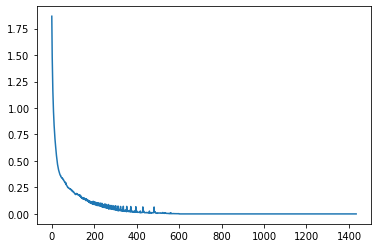

In [ ]:
%time value_final, error_stack = jitted_learner_fn(v_init)
plt.plot(range(n_iters),error_stack)